# Clean 100 frames

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from IPython.display import display
import re
import random
%matplotlib inline

In [2]:

# Function to display the images and let the user decide if they want to keep or remove
def display_images(subject_img, frame_images):
    # Calculate the grid dimensions based on the number of images
    rows = (len(frame_images) // 10) + (1 if len(frame_images) % 10 != 0 else 0)
    
    fig, axes = plt.subplots(rows + 1, 10, figsize=(15, rows * 1.5))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    
    # Show the subject image
    ax = axes[0, 0]
    ax.imshow(subject_img)
    ax.axis('off')
    ax.set_title("Subject Image")

    # Plot the miniatures for the frames
    for i in range(1, rows + 1):
        for j in range(10):
            idx = (i - 1) * 10 + j
            if idx < len(frame_images):
                ax = axes[i, j]
                ax.imshow(frame_images[idx])
                ax.axis('off')
                
                # Add the index number in the bottom-right corner of the image
                ax.text(0.95, 0.05, str(idx + 1), color='white', fontsize=10,
                        transform=ax.transAxes, ha='right', va='bottom', weight='bold')
    
    plt.show()

In [3]:
# Function to remove frames based on user-defined range
def remove_images_in_range(batch, user_range):
    """Remove frames based on user input range (e.g., 1-5, 25-45)."""
    try:
        # Parse the range input
        if '-' in user_range:
            start, end = map(int, user_range.split('-'))
            # Make sure start and end are within bounds
            if start < 1 or end > len(batch):
                print(f"Invalid range! Valid range is 1-{len(batch)}.")
                return []
            # Return the frames to remove, converting to 0-based index
            return [batch[i-1] for i in range(start, end+1)]
        else:
            print("Invalid range format. Please use the format 'start-end'.")
            return []
    except ValueError:
        print("Error: Invalid range format. Please use 'start-end'.")
        return []

In [4]:


# Function to parse user input for ranges or specific numbers
def parse_remove_input(user_input, total_frames):
    frames_to_remove = set()

    # Handle ranges (e.g., [2, 78]) and specific numbers (e.g., 3,7,9)
    try:
        # Check if the input is a range of numbers (e.g., [2, 78])
        if user_input.startswith('[') and user_input.endswith(']'):
            range_input = user_input[1:-1]  # Remove the square brackets
            ranges = range_input.split(',')
            start, end = map(int, ranges)
            if 1 <= start <= end <= total_frames:
                frames_to_remove = set(range(start, end + 1))
            else:
                print("Invalid range, skipping removal.")
        
        # Check if the input contains specific numbers separated by commas (e.g., 3,7,9)
        else:
            specific_frames = user_input.split(',')
            frames_to_remove = set(int(frame.strip()) for frame in specific_frames if frame.strip().isdigit())
            frames_to_remove = {frame for frame in frames_to_remove if 1 <= frame <= total_frames}

    except ValueError:
        print("Invalid input format. Please enter a valid range or specific frame numbers.")

    return frames_to_remove


In [5]:

# Function to process the frames and allow user input
def process_frames(subject_id, subject_img, frames_dir, history_stack):
    # Get all camera directories under subject
    camera_dirs = [d for d in os.listdir(frames_dir) if os.path.isdir(os.path.join(frames_dir, d))]
    
    # Iterate over each camera
    for camera in camera_dirs:
        camera_frame_dir = os.path.join(frames_dir, camera, "frames")
        frame_files = [f for f in os.listdir(camera_frame_dir) if f.endswith('.png')]

        # Shuffle the frames so we don't go in order
        random.shuffle(frame_files)
        
        # Process frames in batches of 50
        batch_size = 50
        for i in range(0, len(frame_files), batch_size):
            batch = frame_files[i:i+batch_size]
            frame_images = [mpimg.imread(os.path.join(camera_frame_dir, frame)) for frame in batch]
            display_images(subject_img, frame_images)
            
            # Get user input: k (keep) or r (remove), or b (back)
            while True:
                user_input = input(f"Do you want to keep or remove these {len(batch)} images? (k/r/b): ")
                
                if user_input == 'k':
                    print("Keeping images...")
                    history_stack.append(('k', batch))
                    break
                elif user_input == 'r':
                    print("You chose to remove images.")
                    print(f"Available frames to remove: 1 to {len(batch)}")
                    user_range = input("Enter a range of frames to remove (e.g., [1, 5], 25-45), or press Enter to remove all 50: ")
                    
                    # If no range provided, remove all
                    if not user_range:
                        print(f"Removing all {len(batch)} images...")
                        frames_to_remove = batch
                    else:
                        frames_to_remove = parse_remove_input(user_range, len(batch))
                    
                    if frames_to_remove:
                        # Remove the selected frames
                        for frame_idx in frames_to_remove:
                            frame = batch[frame_idx - 1]  # Convert to 0-based index
                            frame_path = os.path.join(camera_frame_dir, frame)
                            if os.path.exists(frame_path):
                                # os.remove(frame_path)
                                print('Remove frame: ', frame_path)
                        history_stack.append(('r', batch, frames_to_remove))  # Save removal action
                        break
                elif user_input == 'b':  # If 'b' (back), undo last action
                    if history_stack:
                        last_action = history_stack.pop()  # Pop the last action
                        print("Going back to previous iteration...")
                        if last_action[0] == 'r':  # If last action was removal, restore the frames
                            # Restore the removed frames
                            frames_to_restore = last_action[2]
                            for frame in frames_to_restore:
                                frame_path = os.path.join(camera_frame_dir, frame)
                                # Assuming you have a backup of removed frames, restore them.
                                print(f"Restoring frame: {frame}")
                                # Example: shutil.copy(frame_backup_path, frame_path)
                        # Re-display the batch again
                        display_images(subject_img, frame_images)
                    else:
                        print("No action to go back to.")
                else:
                    print("Invalid input, please enter 'k', 'r' or 'b'.")


In [6]:


# Function to process each subject
def process_subjects(first_root, second_root):
    # Get a list of image files in the first root directory
    image_files = [f for f in os.listdir(first_root) if f.endswith('.png')]  # Assuming the images are PNG
    
    # Extract subject IDs from the filenames
    subject_ids = set()  # Using a set to avoid duplicates
    for image_file in image_files:
        match = re.match(r"([a-zA-Z0-9_-]+)_set1_wb0_1_0.rs-image-5.png", image_file)
        if match:
            subject_ids.add(match.group(1))  # Extract the subject ID (first part of the filename)
    
    print('Found subject IDs: ', subject_ids)
    
    # Initialize history stack to allow going back
    history_stack = []

    for subject_id in subject_ids:
        # Load the subject image from the first root
        subject_img_path = os.path.join(first_root, f"{subject_id}_set1_wb0_1_0.rs-image-5.png")
        if os.path.exists(subject_img_path):
            subject_img = mpimg.imread(subject_img_path)
        else:
            print(f"Subject image for {subject_id} not found in {first_root}. Skipping...")
            continue
        
        # Process frames for this subject in the second root
        subject_frame_dir = os.path.join(second_root, subject_id)
        if os.path.exists(subject_frame_dir):
            process_frames(subject_id, subject_img, subject_frame_dir, history_stack)
        else:
            print(f"Frames for subject {subject_id} not found in {second_root}. Skipping...")


Found subject IDs:  {'K22602', 'K21603', 'K25560', 'K21578', 'K21609', 'K22603', 'K21569', 'K25596', 'K21599', 'K22599', 'K20569', 'K25588', 'K24594', 'K20615', 'K25584', 'K23618', 'K23560', 'K25570', 'K25563', 'K20614', 'K22617', 'K25592', 'K22606', 'K21600', 'K23601', 'K20617', 'K23562', 'K22564', 'K21618', 'K23576', 'K22562', 'K21593', 'K24614', 'K24611', 'K25615', 'K24615', 'K24572', 'K23617', 'K24564', 'K21615', 'K20568', 'K22566', 'K20607', 'K25586', 'K22614', 'K22563', 'K23603', 'K20577', 'K25562', 'K25612', 'K25614', 'K20601', 'K25580', 'K25576', 'K24570', 'K22609', 'K23613', 'K22612', 'K25598', 'K21607', 'K20595', 'K22598', 'K23602', 'K23591', 'K24588', 'K20613', 'K21580', 'K22619', 'K22580', 'K22607', 'K23616', 'K23563', 'K25600', 'K25619', 'K23596', 'K25611', 'K24580', 'K24577', 'K22584', 'K23615', 'K20576', 'K20602', 'K20597', 'K20598', 'K24592', 'K21576', 'K25608', 'K22594', 'K23597', 'K21591', 'K25618', 'K22569', 'K21567', 'K21611', 'K24584', 'K22596', 'K21612', 'K22613',

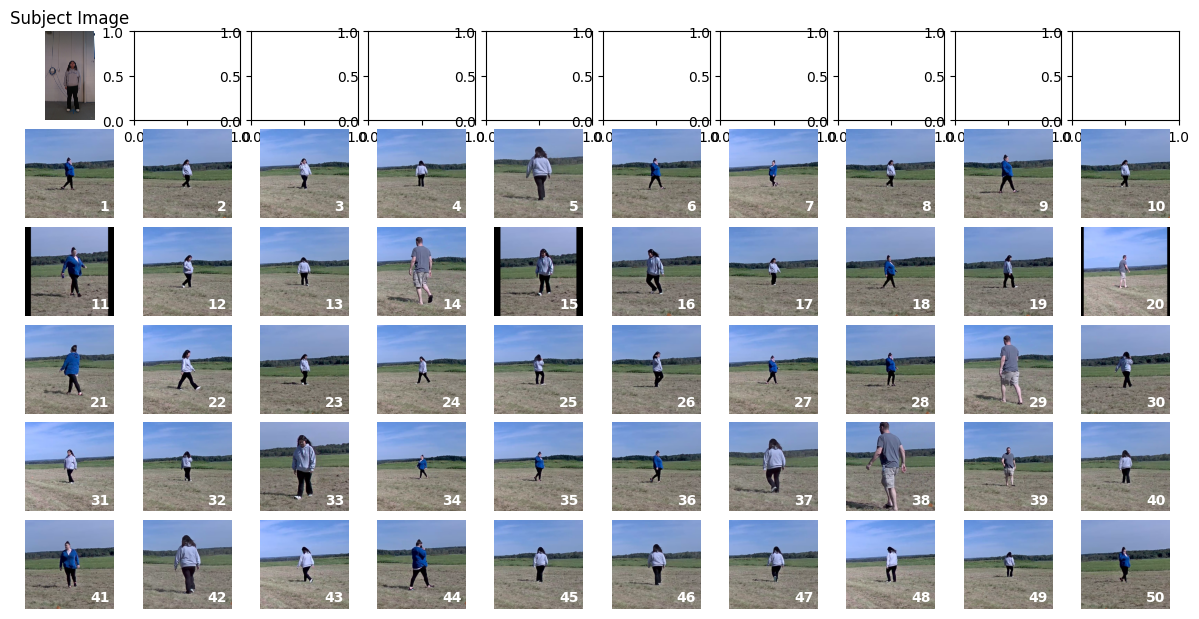

Do you want to keep or remove these 50 images? (k/r/b):  k


Keeping images...


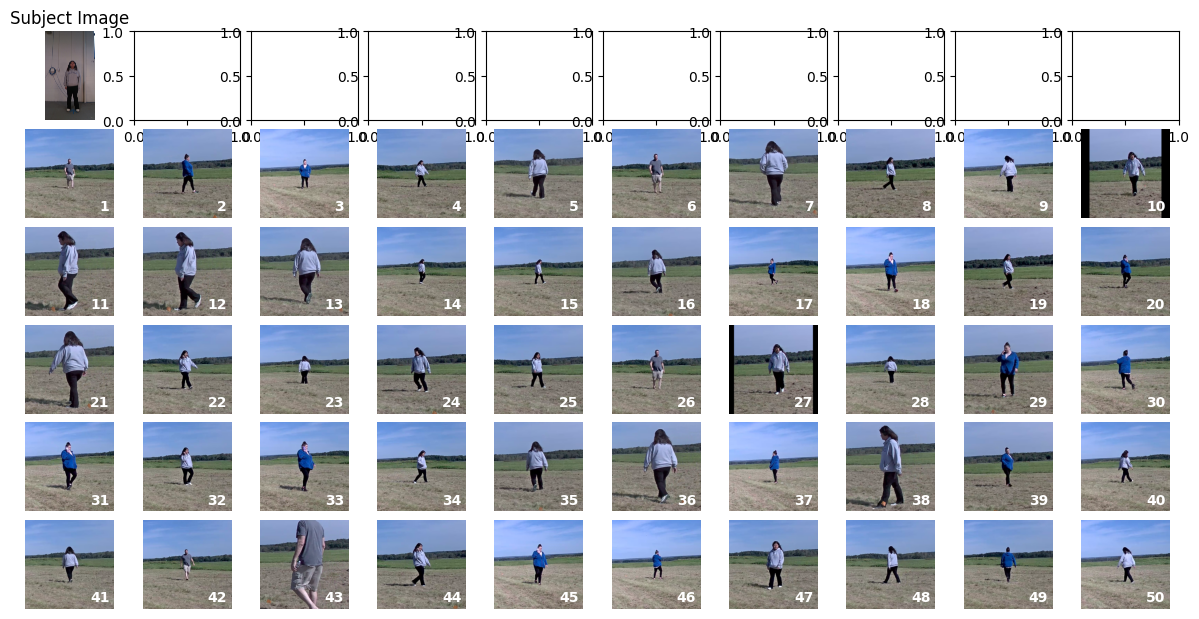

KeyboardInterrupt: Interrupted by user

In [7]:

# Example usage:
first_root = '/home/caio.dasilva/datasets/brc2_rotate/'  # The first directory where the subject images are located
second_root = 'output/'  # The second directory with the frames organized by subject/camera/frames

# Run the process
process_subjects(first_root, second_root)
print('Done')
